In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import yaml

sys.path.append("../")

%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.preprocessing import StandardScaler
from preprocessing.sliding_window import create_windowed_dataset

### Data loading

In [3]:
data_path = '/home/hariub/data/HAR/processed/clean_daphnet_data.csv'
df = pd.read_csv(data_path)

In [4]:
df.head()

,Time,Ankle_acc_x,Ankle_acc_y,Ankle_acc_z,Thigh_acc_x,Thigh_acc_y,Thigh_acc_z,Trunk_acc_x,Trunk_acc_y,Trunk_acc_z,Label,Subject,Run
0,15.0,70.0,39.0,-970.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,31.0,70.0,39.0,-970.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
2,46.0,60.0,49.0,-960.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
3,62.0,60.0,49.0,-960.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
4,78.0,50.0,39.0,-960.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [5]:
FEATURES = ['Ankle_acc_x', 'Ankle_acc_y', 'Ankle_acc_z', 'Thigh_acc_x','Thigh_acc_y', 'Thigh_acc_z', 'Trunk_acc_x', 'Trunk_acc_y','Trunk_acc_z']
LABEL = ['Label']

In [6]:
df = df.fillna(0)
scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

df = df[df['Label'] != 2]

In [7]:
hyperparameters = yaml.load(open('../configs/metadata.yaml', mode='r'), Loader=yaml.FullLoader)

metadata = yaml.load(open('../configs/metadata.yaml', mode='r'), Loader=yaml.FullLoader)['daphnet_preprocess']

In [8]:
train_df = df[(df['Subject'] != 2) & (df['Subject'] != 9)]
test_df = df[df['Subject'] == 2]
val_df = df[df['Subject'] == 9]

SLIDING_WINDOW_LENGTH = metadata['sliding_win_len']
SLIDING_WINDOW_STEP = metadata['sliding_win_stride']
N_WINDOW, N_TIMESTEP = metadata['n_window'], metadata['n_timestep']

# FEATURES = metadata['feature_list']

X_train, y_train = create_windowed_dataset(
    train_df, FEATURES, 'Label', window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_val, y_val = create_windowed_dataset(
    val_df, FEATURES, 'Label', window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_test, y_test = create_windowed_dataset(
    test_df, FEATURES, 'Label', window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)

X_train = X_train.reshape(
    (X_train.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_val = X_val.reshape(
    (X_val.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_test = X_test.reshape(
    (X_test.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))

y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [9]:
# from preprocessing.utils import get_train_test_data
from model.hierarchical_self_attention_model import HSA_model_session_guided_window

In [10]:
print(X_train.shape)
print(y_train.shape)

(9296, 10, 32, 9)
(9296, 2)


In [11]:
y_train_mid = np.repeat(np.expand_dims(y_train, axis=1), repeats=metadata['n_window'], axis=1)
y_val_mid = np.repeat(np.expand_dims(y_val, axis=1), repeats=metadata['n_window'], axis=1)
y_test_mid = np.repeat(np.expand_dims(y_test, axis=1), repeats=metadata['n_window'], axis=1)

In [12]:
y_train_mid.shape

(9296, 10, 2)

In [13]:
hparam_file = open('../configs/hyperparameters.yaml', mode='r')
hyperparameters = yaml.load(hparam_file, Loader=yaml.FullLoader)
DATASET_NAME = 'daphnet'
hparams_all = hyperparameters['HSA_model']
hparams = hparams_all[DATASET_NAME]

hparams['n_window'], hparams['n_timesteps'], hparams['n_features'], hparams['n_outputs'] = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
hparams['n_outputs_window']=  y_train.shape[1]

## Training

In [14]:
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
# print(gpus)
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
device_list = ['/gpu:'+str(i) for i in range(6, 8)]
strategy = tf.distribute.MirroredStrategy(devices=device_list)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = HSA_model_session_guided_window(**hparams).get_compiled_model()

6 Physical GPUs, 6 Logical GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Number of devices: 2


In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 32, 9)]  0                                            
__________________________________________________________________________________________________
multi_window_encoder (MultiWind ((None, None, 64), ( 350144      input_1[0][0]                    
__________________________________________________________________________________________________
modality_encoder_block_3 (Modal (None, None, 64)     104000      multi_window_encoder[0][0]       
__________________________________________________________________________________________________
combined_sensor_self_attention_ ((None, 64), (None,  49856       modality_encoder_block_3[0][0]   
____________________________________________________________________________________________

In [ ]:
model.fit(X_train, [y_train_mid, y_train], batch_size=len(device_list) * 128, epochs=50, validation_data=(X_val, [y_val_mid, y_val]), use_multiprocessing=True)

Epoch 1/50
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/tas

In [17]:
pred_mid, pred_sess = model.predict(X_test, batch_size=len(device_list) * 64)

In [18]:
# labels_map = {1:'lying',2:'sitting',3:'standing',4:'walking',5:'running',6:'cycling',7:'Nordic walking',
#               11:'ascending stairs',12:'descending stairs',13:'vacuum cleaning',
#               14:'ironing', 18:'rope jumping'}
# class_names = list(labels_map.values())

In [19]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.65      0.71       891
           1       0.73      0.84      0.78       984

    accuracy                           0.75      1875
   macro avg       0.76      0.75      0.75      1875
weighted avg       0.76      0.75      0.75      1875



In [31]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1)))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82       135
           1       0.77      0.92      0.84       122

    accuracy                           0.83       257
   macro avg       0.84      0.83      0.83       257
weighted avg       0.84      0.83      0.83       257



In [32]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1)))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82       135
           1       0.77      0.92      0.84       122

    accuracy                           0.83       257
   macro avg       0.84      0.83      0.83       257
weighted avg       0.84      0.83      0.83       257



In [33]:
# activity_map

<AxesSubplot:>

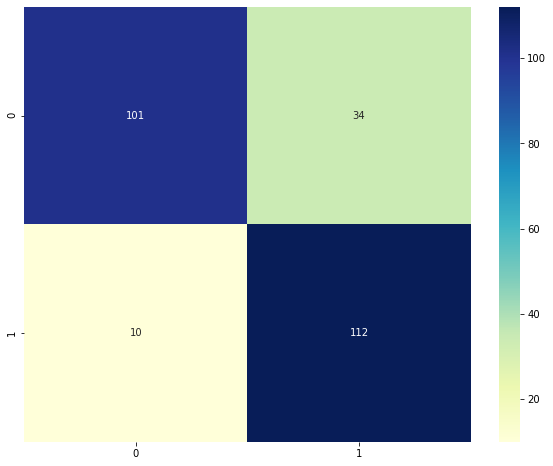

In [34]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1))
# activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

In [35]:
y_test_mid.shape

(257, 15, 3)

In [36]:
pred_mid.shape

(257, 15, 3)

In [37]:
print(classification_report(np.argmax(y_test_mid.reshape(-1, 3), axis=1), np.argmax(pred_mid.reshape(-1, 3), axis=1)))

              precision    recall  f1-score   support

           0       0.85      0.75      0.80      2025
           1       0.76      0.86      0.81      1830

    accuracy                           0.80      3855
   macro avg       0.81      0.81      0.80      3855
weighted avg       0.81      0.80      0.80      3855



<AxesSubplot:>

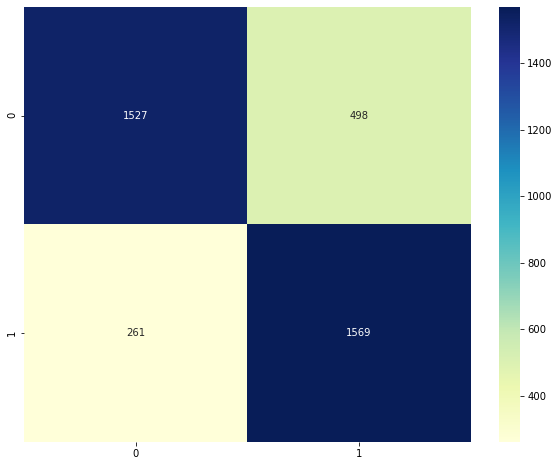

In [38]:
confm = confusion_matrix(np.argmax(y_test_mid.reshape(-1, 3), axis=1), np.argmax(pred_mid.reshape(-1, 3), axis=1))
# activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")